In [1]:
import numpy as np
import plumed
from matplotlib import pyplot as plt

In [2]:
colvar=plumed.read_as_pandas("COLVAR")
colvar

,time,n,lambda,metad.bias,metad.work,uwall.bias,uwall.force2,lwall.bias,lwall.force2
0,0.00,2.110478,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
1,0.02,2.031148,0.0,0.000000,0.000000e+00,0.0,0.0,0.0,0.0
2,0.04,1.942041,0.0,4.415230,1.238094e+01,0.0,0.0,0.0,0.0
3,0.06,1.822416,0.0,1.040391,2.179542e+01,0.0,0.0,0.0,0.0
4,0.08,1.760122,0.0,7.339894,3.435510e+01,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
9999996,199999.92,2.371331,21.0,1581.403885,5.028873e+06,0.0,0.0,0.0,0.0
9999997,199999.94,2.386239,18.0,1613.513975,5.028873e+06,0.0,0.0,0.0,0.0
9999998,199999.96,2.430896,20.0,1593.145878,5.028874e+06,0.0,0.0,0.0,0.0
9999999,199999.98,2.464220,18.0,1612.793521,5.028874e+06,0.0,0.0,0.0,0.0


In [3]:
# extract lambda=0 or 39
colvar0=colvar[colvar["lambda"]==0.0]
colvar39=colvar[colvar["lambda"]==39.0]

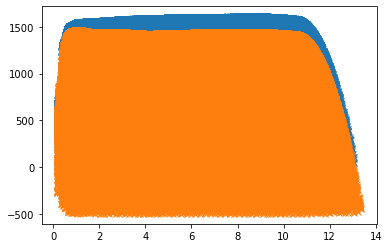

In [9]:
# this is a quick way to plot the "envelope" of the bias on n
# it's useful on the fly, but the correct way is with sum_hills (see below)
plt.plot(colvar39["n"],colvar39["metad.bias"],"x")
plt.plot(colvar0["n"],colvar0["metad.bias"]-500,"x")
# the -50 is just to see both envelopes. They are different as expected.
# this means the F along the angle is the same at lambda=0 or lambda=1

In [28]:
# we then try sum hills on 2D
!plumed sum_hills --hills HILLS_2D --min 0.0,0.0 --max 39.0,14 --bin 39,100

PLUMED: PLUMED is starting
PLUMED: Version: 2.7.0 (git: Unknown) compiled on Dec 23 2020 at 20:47:11
PLUMED: Please cite these papers when using PLUMED [1][2]
PLUMED: For further information see the PLUMED web page at http://www.plumed.org
PLUMED: Root: /Users/bussi/.conda/envs/work/lib/plumed
PLUMED: For installed feature, see /Users/bussi/.conda/envs/work/lib/plumed/src/config/config.txt
PLUMED: Molecular dynamics engine: 
PLUMED: Precision of reals: 8
PLUMED: Running over 1 node
PLUMED: Number of threads: 1
PLUMED: Cache line size: 512
PLUMED: Number of atoms: 1
PLUMED: File suffix: 
PLUMED: Timestep: 0.000000
PLUMED: KbT has not been set by the MD engine
PLUMED: It should be set by hand where needed
PLUMED: Relevant bibliography:
PLUMED:   [1] The PLUMED consortium, Nat. Methods 16, 670 (2019)
PLUMED:   [2] Tribello, Bonomi, Branduardi, Camilloni, and Bussi, Comput. Phys. Commun. 185, 604 (2014)
PLUMED: Please read and cite where appropriate!
PLUMED: Finished setup
PLUMED: Action F

In [30]:
fes=plumed.read_as_pandas("fes.dat")
fes

,lambda,n,file.free,der_lambda,der_n
0,0.0,0.0,-0.884071,-0.0,-64.833376
1,1.0,0.0,-0.827123,-0.0,-60.868094
2,2.0,0.0,-0.799114,-0.0,-58.846541
3,3.0,0.0,-0.770067,-0.0,-56.730408
4,4.0,0.0,-0.694901,-0.0,-51.565505
...,...,...,...,...,...
4035,35.0,14.0,-0.000000,-0.0,-0.000000
4036,36.0,14.0,-0.000000,-0.0,-0.000000
4037,37.0,14.0,-0.000000,-0.0,-0.000000
4038,38.0,14.0,-0.000000,-0.0,-0.000000


In [37]:
# I do the projection by hand (sum_hills doesn't handle well the numerical problems with exp, should be improved)
FF=[]
for i in range(40):
    f=np.array(fes["file.free"]).reshape((101,40)).copy()[:,i]
    m=np.min(f) # this is the trick that should be implemented in sum_hills
    FF.append(m-2.5*np.sum(np.exp(-(f-m)/2.5)))  

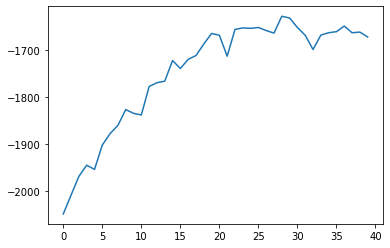

In [39]:
plt.plot(FF)

In [43]:
(FF[-1]-FF[0])/2.5
# this is DF in kBT units, ~ 150

150.46714563649047

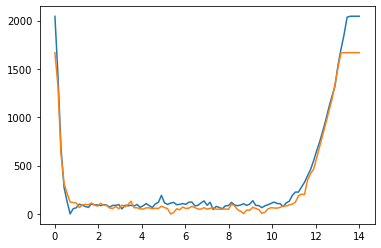

In [45]:
fes0=fes[fes["lambda"]==0.0]
fes39=fes[fes["lambda"]==39.0]
plt.plot(fes0["n"],fes0["file.free"]-np.min(fes0["file.free"]))
plt.plot(fes39["n"],fes39["file.free"]-np.min(fes39["file.free"]))

In [46]:
# The blue line (lambda=0) suggests that there is a minimum close to n==0. I am not sure it was a good idea to use the walls then